# European Soccer Data Analysis
### Data Engineering Capstone Project

#### Exploratory Data Analysis

In this section we will connect to postgres and get some insights about our data. We will form those insights in the shape of questions and answers to make it easier and more understandable.


In [37]:
# Imports and installs
import pandas as pd
import numpy as np
import re
import requests
import psycopg2
from datetime import datetime, date
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
#establishing the connection
postgres_conn = psycopg2.connect(database="european_soccer", user='postgres', password='[your_password]', host='127.0.0.1', port= '5432')
postgres_conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = postgres_conn.cursor()


print("Database connected successfully........")

Database connected successfully........


#### **1. Who are the most 10 rated players?**

In [30]:
top_10_players_rating = pd.read_sql("""SELECT  
                                        DISTINCT player_name AS Player_Name
                                        ,dp.age AS Player_Age 
                                        ,round(avg(dpa.overall_rating)::NUMERIC ,2) AS Avg_Overall_Rating 
                                    FROM dim_player dp 
                                    LEFT JOIN dim_player_attr dpa 
                                    ON dp.player_fifa_id  = dpa.player_fifa_id 
                                    WHERE dpa.overall_rating IS NOT null
                                    GROUP BY 1,2
                                    ORDER BY 3 DESC 
                                    LIMIT 10""", postgres_conn)

*As we can see below **Cristiano Ronaldo** has the most average overall rating among all players!*

In [40]:
top_10_players_rating

,player_name,player_age,avg_overall_rating
0,Cristiano Ronaldo,38,91.11
1,Zlatan Ibrahimovic,42,88.33
2,Franck Ribery,40,88.11
3,Xavi Hernandez,43,87.88
4,Andres Iniesta,39,87.78
5,Wayne Rooney,38,87.78
6,Iker Casillas,42,87.67
7,Arjen Robben,39,87.67
8,Cesc Fabregas,36,86.89
9,David Silva,37,86.67


#### **2. Who are the most top 10 players by time spent in the field?**

In [100]:
top_10_time_in_field = pd.read_sql("""SELECT  
                                            DISTINCT player_name 
                                            ,max(dpa.at_the_time_age) - min(dpa.at_the_time_age) AS time_in_field
                                        FROM dim_player dp 
                                        LEFT JOIN dim_player_attr dpa 
                                        ON dp.player_fifa_id  = dpa.player_fifa_id 
                                        WHERE age IS NOT NULL AND dpa.at_the_time_age IS NOT NULL 
                                        GROUP BY 1
                                        ORDER BY 2 DESC 
                                        LIMIT 10""", postgres_conn)

*Wow! **Marco Rossi** spent 13 years playing.*

In [101]:
top_10_time_in_field

,player_name,time_in_field
0,Marco Rossi,13
1,Tiago,10
2,Stephen Ireland,10
3,Tono,10
4,Aiden McGeady,9
5,Sisi,9
6,Ricardo,9
7,Fabio Quagliarella,9
8,Daniele De Rossi,8
9,Franco Brienza,8


#### **3. And here we come to the most asked question. Who're the most 10 ranked players by wage?**

In [51]:
top_10_wages = pd.read_sql("""SELECT  
                                DISTINCT player_name 
                                ,max(dpa.wage_in_euro::NUMERIC) wage_in_euro
                            FROM dim_player dp 
                            LEFT JOIN dim_player_attr dpa 
                            ON dp.player_fifa_id  = dpa.player_fifa_id 
                            WHERE dpa.wage_in_euro IS NOT NULL 
                            GROUP BY 1
                            ORDER BY 2 DESC 
                            LIMIT 10""", postgres_conn)

*Again with **Cristiano Ronaldo**! Way to go Cristiano!*

In [52]:
top_10_wages

,player_name,wage_in_euro
0,Cristiano Ronaldo,475000.0
1,Manuel Neuer,300000.0
2,Arjen Robben,275000.0
3,Zlatan Ibrahimovic,275000.0
4,Andres Iniesta,250000.0
5,Eden Hazard,240000.0
6,Franck Ribery,240000.0
7,Robin van Persie,240000.0
8,Karim Benzema,230000.0
9,Mesut Oezil,230000.0


#### **4. Let's switch to the teams now shall we?!. Which top 10 ranked teams by build up attributes?**
And by buildup attributes here we mean build up play speed + build up play dribbling + build up play passing

In [53]:
top_10_build_up_attr = pd.read_sql("""SELECT  
                                            team_name
                                            ,sum(dta.build_up_play_speed+dta.build_up_play_dribbling+dta.build_up_play_passing) build_up_play_attr
                                        FROM dim_team dt 
                                        LEFT JOIN dim_team_attr dta 
                                        ON CAST(dt.team_api_id AS NUMERIC) = dta.team_api_id
                                        WHERE dta.build_up_play_speed IS NOT NULL 
                                        AND dta.build_up_play_dribbling IS NOT NULL 
                                        AND dta.build_up_play_passing IS NOT NULL 
                                        GROUP BY 1
                                        ORDER BY 2 DESC 
                                        LIMIT 10""", postgres_conn)

*It's clearly **Udinese** is getting number 1 on this. But htere isn't a big difference between the first and the last team*

In [54]:
top_10_build_up_attr

,team_name,build_up_play_attr
0,Udinese,390
1,Torino,383
2,Podbeskidzie Bielsko-Biała,382
3,Chievo Verona,374
4,Korona Kielce,370
5,Sassuolo,370
6,Genoa,368
7,Piast Gliwice,366
8,Livorno,366
9,Inter,363


#### **5. And to continue with the curiosity about money. Which are the most paying teams?**


In [55]:
top_10_paying_teams = pd.read_sql("""SELECT  
                                        team_name
                                        ,maX(dp.wage_in_euro::NUMERIC) wage_in_euro
                                    FROM dim_team dt 
                                    LEFT JOIN dim_player_attr dp
                                    ON dp.team = dt.team_name 
                                    WHERE dp.wage_in_euro IS NOT NULL 
                                    GROUP BY 1
                                    ORDER BY 2 DESC 
                                    LIMIT 10""", postgres_conn)

***Real Madrid** comes at first with a big difference than *Juventus*.*

In [58]:
top_10_paying_teams

,team_name,wage_in_euro
0,Real Madrid,475000.0
1,FC Bayern München,300000.0
2,Paris Saint Germain,275000.0
3,FC Barcelona,250000.0
4,Chelsea,240000.0
5,Manchester United,240000.0
6,Arsenal,230000.0
7,Borussia Dortmund,220000.0
8,Manchester City,220000.0
9,Juventus,190000.0


#### **6. Now, Which team has the most powerful defense?!**
Here we rank teams by defense attributes which is the summation of (deffense pressure, deffense aggression and deffense team width)

In [102]:
top_10_defense_attr = pd.read_sql("""SELECT  
                                        team_name
                                        ,sum(dta.deffense_pressure +dta.deffense_aggression +dta.deffense_team_width) defense_attr
                                    FROM dim_team dt 
                                    LEFT JOIN dim_team_attr dta 
                                    ON CAST(dt.team_api_id AS NUMERIC) = dta.team_api_id
                                    WHERE dta.deffense_pressure IS NOT NULL 
                                    AND dta.deffense_aggression IS NOT NULL 
                                    AND dta.deffense_team_width IS NOT NULL 
                                    GROUP BY 1
                                    ORDER BY 2 DESC 
                                    LIMIT 10""", postgres_conn)

*Way to go **FC Barcelona**!*

In [103]:
top_10_defense_attr

,team_name,defense_attr
0,FC Barcelona,1112
1,Wisła Kraków,1056
2,Cercle Brugge,1047
3,Borussia Dortmund,1047
4,Legia Warszawa,1041
5,Werder Bremen,1041
6,Anderlecht,1027
7,Burnley,1019
8,Celtic,1019
9,Ajax,1008


#### **7. Let's see, who are the most 10 moving players between teams?**

In [63]:
top_10_moving_players = pd.read_sql("""SELECT  
                                            player_name 
                                        ,count(dpa.team) as teams_count
                                        FROM dim_player dp  
                                        LEFT JOIN dim_player_attr dpa 
                                        ON dpa.player_fifa_id = dp.player_fifa_id 
                                        GROUP BY 1
                                        ORDER BY 2 DESC 
                                        LIMIT 10 """, postgres_conn)

***Tiago and Eduardo** moved 14 times! WOW!*

In [64]:
top_10_moving_players

,player_name,teams_count
0,Tiago,14
1,Eduardo,14
2,Juanfran,13
3,Ricardo,12
4,Curtis Davies,11
5,Gareth Bale,11
6,David Lopez,10
7,Francois Clerc,10
8,Jeremy Clement,10
9,Lukasz Fabianski,10


#### **8. We can take *Tiago* as a small sample and see if there is a correlation between age and wage.**

In [75]:
tiago_wages_and_age = pd.read_sql("""SELECT  
                                        player_name 
                                        ,dpa.at_the_time_age 
                                        ,avg(dpa.wage_in_euro::NUMERIC) average_wage_in_euro
                                    FROM dim_player dp  
                                    LEFT JOIN dim_player_attr dpa 
                                    ON dpa.player_fifa_id = dp.player_fifa_id 
                                    WHERE player_name = 'Tiago'
                                    AND dpa.wage_in_euro::NUMERIC != 0
                                    GROUP BY 1,2""", postgres_conn)

*As we see here there is a clear correlation between age and wage, the peak for the wage is at early thirties and there is a huge drop at the second half of his thirties.*

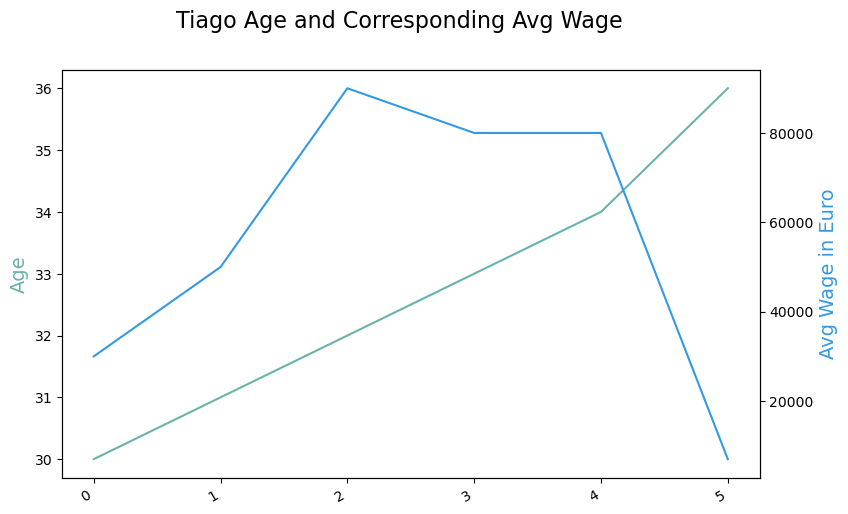

In [84]:
COLOR_AGE = "#69b3a9"
COLOR_WAGE = "#3399e7"

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()
ax1.plot(tiago_wages_and_age['at_the_time_age'], color = COLOR_AGE)
ax2.plot(tiago_wages_and_age['average_wage_in_euro'], color = COLOR_WAGE);
ax1.set_ylabel("Age", color=COLOR_AGE, fontsize=14)
ax2.set_ylabel("Avg Wage in Euro", color=COLOR_WAGE, fontsize=14)

fig.suptitle("Tiago Age and Corresponding Avg Wage", fontsize=16)
fig.autofmt_xdate()


#### **9. Which are the top 10 leagues that have the most matches count?**

In [88]:
top_10_matches_count_per_league = pd.read_sql("""SELECT  
                                                    dl.league_name  
                                                    ,count(match_id) matches_count
                                                FROM fct_match fm 
                                                LEFT JOIN dim_league dl 
                                                ON dl.league_id = fm.league_id 
                                                GROUP BY 1 
                                                ORDER BY 2 DESC 
                                                LIMIT 10""", postgres_conn)

*Okay, those numbers are somehow bigger than I expected.*

In [89]:
top_10_matches_count_per_league

,league_name,matches_count
0,England Premier League,3040
1,Spain LIGA BBVA,3040
2,France Ligue 1,3040
3,Italy Serie A,3017
4,Netherlands Eredivisie,2448
5,Germany 1. Bundesliga,2448
6,Portugal Liga ZON Sagres,2052
7,Poland Ekstraklasa,1920
8,Scotland Premier League,1824
9,Belgium Jupiler League,1728


#### **10. And now for the teams, which are the most 10 goal scoring teams that played away from their home?**

In [90]:
top_10_away_teams_goals = pd.read_sql("""SELECT  
                                            dt.team_name 
                                            ,sum(away_team_goal) goals_count
                                        FROM fct_match fm 
                                        left JOIN dim_team dt 
                                        ON dt.team_api_id::NUMERIC  = fm.away_team_api_id 
                                        GROUP BY 1 
                                        ORDER BY 2 DESC 
                                        LIMIT 10""", postgres_conn)

***FC Barcelona** Again!, they seem to be a very powerful team!*

In [91]:
top_10_away_teams_goals

,team_name,goals_count
0,FC Barcelona,354
1,Real Madrid,338
2,Celtic,306
3,Ajax,287
4,PSV,282
5,Basel,275
6,FC Bayern München,271
7,Arsenal,267
8,Borussia Dortmund,253
9,Chelsea,250


#### **11. Now with the top 10 scoring home teams.**

In [94]:
top_10_home_teams_goals = pd.read_sql("""SELECT  
                                            dt2.team_name 
                                            ,sum(home_team_goal) goals_count
                                        FROM fct_match fm 
                                        LEFT  JOIN dim_team dt2 
                                        ON dt2.team_api_id::NUMERIC = fm.home_team_api_id 
                                        GROUP BY 1 
                                        ORDER BY 2 DESC 
                                        LIMIT 10""", postgres_conn)

***Real Madrid** is taking the first place, but did you notice that **FC Barcelona** comes at second place? Interesting!. But there is a very noticable point to raise is that the count of goals that teams score at their home is way bigger than away from home*

In [95]:
top_10_home_teams_goals

,team_name,goals_count
0,Real Madrid,505
1,FC Barcelona,495
2,Celtic,389
3,FC Bayern München,382
4,PSV,370
5,Manchester City,365
6,Ajax,360
7,Basel,344
8,Manchester United,338
9,Chelsea,333


#### **12. Let's see if the theory above is right. We will compare the goals count for the most scoring teams at their home to their away score**

In [98]:
top_10_home_teams_goals_vs_away = pd.read_sql("""SELECT 
                                                    a.home_team_name as team_name
                                                    ,a.home_goals_count
                                                    ,b.away_goals_count
                                                FROM  
                                                (SELECT  
                                                    dt2.team_name AS home_team_name
                                                    ,sum(home_team_goal) home_goals_count
                                                FROM fct_match fm 
                                                LEFT  JOIN dim_team dt2 
                                                ON dt2.team_api_id::NUMERIC = fm.home_team_api_id 
                                                GROUP BY 1 
                                                ORDER BY 2 DESC 
                                                LIMIT 10 ) a 
                                                LEFT JOIN 
                                                (SELECT  
                                                    dt2.team_name AS away_team_name
                                                    ,sum(away_team_goal) away_goals_count
                                                FROM fct_match fm 
                                                LEFT  JOIN dim_team dt2 
                                                ON dt2.team_api_id::NUMERIC = fm.away_team_api_id 
                                                GROUP BY 1 ) b 
                                                ON a.home_team_name = b.away_team_name""", postgres_conn)

*There is definitely a correlation between players being away or at their homes. I guess home wins Huh!*

In [99]:
top_10_home_teams_goals_vs_away

,team_name,home_goals_count,away_goals_count
0,Real Madrid,505,338
1,FC Bayern München,382,271
2,PSV,370,282
3,FC Barcelona,495,354
4,Celtic,389,306
5,Chelsea,333,250
6,Manchester City,365,241
7,Ajax,360,287
8,Manchester United,338,244
9,Basel,344,275
